# Aircraft Engine RUL Prediction

In [20]:
import pandas as pd
import numpy as np

#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler #to normalize data
import pywt
import os
# os.chdir("C:/Data/aircraft/")

#for deep learning
import keras
import keras.backend as k
from keras.models import Sequential,Model, load_model
from keras.layers import Dense, LSTM, Activation, Masking, Dropout, Input
from keras.optimizers import RMSprop, Adam
from keras.callbacks import History
from keras import callbacks

In [21]:
# based on data wrangling python notebook
def prepare_data(drop_cols = True):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

    cols_to_drop = ['OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure10', 'SensorMeasure14',
     'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']

    df_train = pd.read_csv('https://raw.githubusercontent.com/ericlrf/rul/main/CMAPSSData/train_FD004.txt',delim_whitespace=True,names=input_file_column_names)
   
    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)

    df_test = pd.read_csv('https://raw.githubusercontent.com/ericlrf/rul/main/CMAPSSData/test_FD004.txt', delim_whitespace=True, names=input_file_column_names)

    if(drop_cols == True):
        df_train = df_train.drop(cols_to_drop, axis = 1)
        df_test = df_test.drop(cols_to_drop, axis = 1)

    y_true = pd.read_csv('https://raw.githubusercontent.com/ericlrf/rul/main/CMAPSSData/RUL_FD004.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index

    
    return df_train, df_test, y_true

In [22]:
def stacked_autoencoder(input_dim, encoding_dim=64):
    # Encoding layers
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(128, activation='relu')(input_layer)
    encoded = Dense(encoding_dim, activation='relu')(encoded)

    # Decoding layers
    decoded = Dense(128, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)

    # Autoencoder = encoder + decoder
    autoencoder = Model(input_layer, decoded)
    
    # Encoder model
    encoder = Model(input_layer, encoded)

    # Compile the model
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    
    return autoencoder, encoder

def wavelet_decomposition(data, wavelet='db1', level=1):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    # For simplicity, we'll concatenate the coefficients into a single array
    return np.concatenate(coeffs)

def data_autoencoder(dftrain,dftest, sensor):
     # Assuming you want to apply the autoencoder on 'SensorMeasure2' column
    data_train = dftrain[sensor].values
    data_test = dftest[sensor].values
    
    # Normalize data (important for autoencoder's performance)
    data_train = data_train / np.max(data_train)
    data_test = data_test / np.max(data_test)
    
    # Train the autoencoder
    autoencoder, encoder = stacked_autoencoder(input_dim=1)
    autoencoder.fit(data_train, data_train, epochs=50, batch_size=256, shuffle=True, validation_data=(data_test, data_test))
    
    # Transform the data using the encoder
    encoded_train = encoder.predict(data_train)
    encoded_test = encoder.predict(data_test)
    
    # Add the transformed data back to the original dataframes
    dftrain[sensor] = encoded_train
    dftest[sensor] = encoded_test
    
    return dftrain, dftest

def prepare_data_with_wavelet(drop_cols=True):
    df_train, df_test, y_true = prepare_data(drop_cols)
    
    # Apply wavelet decomposition on SensorMeasure2 of the training dataset
    data_autoencoder(df_train, df_test,'SensorMeasure2');
    data_autoencoder(df_train, df_test,'SensorMeasure3');
    data_autoencoder(df_train, df_test,'SensorMeasure4');
    data_autoencoder(df_train, df_test,'SensorMeasure7');
    data_autoencoder(df_train, df_test,'SensorMeasure8');
    data_autoencoder(df_train, df_test,'SensorMeasure9');
    data_autoencoder(df_train, df_test,'SensorMeasure11');
    data_autoencoder(df_train, df_test,'SensorMeasure12');
    data_autoencoder(df_train, df_test,'SensorMeasure13');
    data_autoencoder(df_train, df_test,'SensorMeasure15');
    data_autoencoder(df_train, df_test,'SensorMeasure17');
    data_autoencoder(df_train, df_test,'SensorMeasure20');
    data_autoencoder(df_train, df_test,'SensorMeasure21');

    
   
    
    # Similarly, you can apply it on the test dataset or other columns as needed
    
    return df_train, df_test, y_true

df_train, df_test, y_true = prepare_data_with_wavelet(drop_cols=True)
df_train.shape, df_test.shape, y_true.shape



Epoch 1/50
240/240 [==============================] - 2s 3ms/step - loss: 0.6791 - val_loss: 0.6743
Epoch 2/50
240/240 [==============================] - 1s 2ms/step - loss: 0.6691 - val_loss: 0.6637
Epoch 3/50
240/240 [==============================] - 1s 2ms/step - loss: 0.6584 - val_loss: 0.6528
Epoch 4/50
240/240 [==============================] - 1s 3ms/step - loss: 0.6472 - val_loss: 0.6415
Epoch 5/50
240/240 [==============================] - 1s 2ms/step - loss: 0.6354 - val_loss: 0.6290
Epoch 6/50
240/240 [==============================] - 1s 2ms/step - loss: 0.6224 - val_loss: 0.6155
Epoch 7/50
240/240 [==============================] - 1s 2ms/step - loss: 0.6083 - val_loss: 0.6007
Epoch 8/50
240/240 [==============================] - 1s 2ms/step - loss: 0.5927 - val_loss: 0.5841
Epoch 9/50
240/240 [==============================] - 1s 2ms/step - loss: 0.5755 - val_loss: 0.5665
Epoch 10/50
240/240 [==============================] - 1s 2ms/step - loss: 0.5577 - val_loss: 0.5484

240/240 [==============================] - 1s 3ms/step - loss: 0.3660 - val_loss: 0.3638
Epoch 32/50
240/240 [==============================] - 1s 2ms/step - loss: 0.3650 - val_loss: 0.3630
Epoch 33/50
240/240 [==============================] - 1s 3ms/step - loss: 0.3643 - val_loss: 0.3624
Epoch 34/50
240/240 [==============================] - 1s 3ms/step - loss: 0.3639 - val_loss: 0.3621
Epoch 35/50
240/240 [==============================] - 1s 3ms/step - loss: 0.3636 - val_loss: 0.3619
Epoch 36/50
240/240 [==============================] - 1s 3ms/step - loss: 0.3634 - val_loss: 0.3617
Epoch 37/50
240/240 [==============================] - 1s 2ms/step - loss: 0.3633 - val_loss: 0.3616
Epoch 38/50
240/240 [==============================] - 1s 2ms/step - loss: 0.3633 - val_loss: 0.3616
Epoch 39/50
240/240 [==============================] - 1s 3ms/step - loss: 0.3632 - val_loss: 0.3615
Epoch 40/50
240/240 [==============================] - 1s 3ms/step - loss: 0.3632 - val_loss: 0.3615
Ep

240/240 [==============================] - 1s 3ms/step - loss: 0.6856 - val_loss: 0.6854
Epoch 11/50
240/240 [==============================] - 1s 3ms/step - loss: 0.6850 - val_loss: 0.6848
Epoch 12/50
240/240 [==============================] - 1s 3ms/step - loss: 0.6843 - val_loss: 0.6841
Epoch 13/50
240/240 [==============================] - 1s 3ms/step - loss: 0.6837 - val_loss: 0.6835
Epoch 14/50
240/240 [==============================] - 1s 3ms/step - loss: 0.6831 - val_loss: 0.6829
Epoch 15/50
240/240 [==============================] - 1s 2ms/step - loss: 0.6824 - val_loss: 0.6822
Epoch 16/50
240/240 [==============================] - 1s 3ms/step - loss: 0.6817 - val_loss: 0.6816
Epoch 17/50
240/240 [==============================] - 1s 3ms/step - loss: 0.6811 - val_loss: 0.6809
Epoch 18/50
240/240 [==============================] - 1s 3ms/step - loss: 0.6804 - val_loss: 0.6801
Epoch 19/50
240/240 [==============================] - 1s 2ms/step - loss: 0.6795 - val_loss: 0.6793
Ep

240/240 [==============================] - 1s 2ms/step - loss: 0.2394 - val_loss: 0.2394
Epoch 41/50
240/240 [==============================] - 1s 2ms/step - loss: 0.2393 - val_loss: 0.2394
Epoch 42/50
240/240 [==============================] - 1s 3ms/step - loss: 0.2393 - val_loss: 0.2394
Epoch 43/50
240/240 [==============================] - 1s 2ms/step - loss: 0.2393 - val_loss: 0.2394
Epoch 44/50
240/240 [==============================] - 1s 3ms/step - loss: 0.2393 - val_loss: 0.2394
Epoch 45/50
240/240 [==============================] - 1s 3ms/step - loss: 0.2393 - val_loss: 0.2393
Epoch 46/50
240/240 [==============================] - 1s 2ms/step - loss: 0.2392 - val_loss: 0.2393
Epoch 47/50
240/240 [==============================] - 1s 3ms/step - loss: 0.2392 - val_loss: 0.2393
Epoch 48/50
240/240 [==============================] - 1s 3ms/step - loss: 0.2392 - val_loss: 0.2393
Epoch 49/50
240/240 [==============================] - 1s 3ms/step - loss: 0.2392 - val_loss: 0.2393
Ep

240/240 [==============================] - 1s 3ms/step - loss: 0.4193 - val_loss: 0.4113
Epoch 20/50
240/240 [==============================] - 1s 3ms/step - loss: 0.4030 - val_loss: 0.3963
Epoch 21/50
240/240 [==============================] - 1s 3ms/step - loss: 0.3893 - val_loss: 0.3840
Epoch 22/50
240/240 [==============================] - 1s 3ms/step - loss: 0.3782 - val_loss: 0.3741
Epoch 23/50
240/240 [==============================] - 1s 3ms/step - loss: 0.3694 - val_loss: 0.3666
Epoch 24/50
240/240 [==============================] - 1s 3ms/step - loss: 0.3628 - val_loss: 0.3609
Epoch 25/50
240/240 [==============================] - 1s 3ms/step - loss: 0.3579 - val_loss: 0.3568
Epoch 26/50
240/240 [==============================] - 1s 3ms/step - loss: 0.3544 - val_loss: 0.3539
Epoch 27/50
240/240 [==============================] - 1s 3ms/step - loss: 0.3519 - val_loss: 0.3519
Epoch 28/50
240/240 [==============================] - 1s 3ms/step - loss: 0.3503 - val_loss: 0.3505
Ep

240/240 [==============================] - 1s 3ms/step - loss: 0.6595 - val_loss: 0.6594
Epoch 50/50
1288/1288 [==============================] - 1s 759us/step
Epoch 1/50
240/240 [==============================] - 2s 3ms/step - loss: 0.6666 - val_loss: 0.6623
Epoch 2/50
240/240 [==============================] - 1s 3ms/step - loss: 0.6577 - val_loss: 0.6527
Epoch 3/50
240/240 [==============================] - 1s 3ms/step - loss: 0.6476 - val_loss: 0.6421
Epoch 4/50
240/240 [==============================] - 1s 3ms/step - loss: 0.6363 - val_loss: 0.6299
Epoch 5/50
240/240 [==============================] - 1s 3ms/step - loss: 0.6232 - val_loss: 0.6158
Epoch 6/50
240/240 [==============================] - 1s 3ms/step - loss: 0.6080 - val_loss: 0.5992
Epoch 7/50
240/240 [==============================] - 1s 3ms/step - loss: 0.5903 - val_loss: 0.5805
Epoch 8/50
240/240 [==============================] - 1s 3ms/step - loss: 0.5706 - val_loss: 0.5597
Epoch 9/50
240/240 [====================

240/240 [==============================] - 1s 3ms/step - loss: 0.4363 - val_loss: 0.4303
Epoch 29/50
240/240 [==============================] - 1s 3ms/step - loss: 0.4360 - val_loss: 0.4300
Epoch 30/50
240/240 [==============================] - 1s 3ms/step - loss: 0.4359 - val_loss: 0.4298
Epoch 31/50
240/240 [==============================] - 1s 3ms/step - loss: 0.4358 - val_loss: 0.4297
Epoch 32/50
240/240 [==============================] - 1s 3ms/step - loss: 0.4357 - val_loss: 0.4297
Epoch 33/50
240/240 [==============================] - 1s 3ms/step - loss: 0.4357 - val_loss: 0.4296
Epoch 34/50
240/240 [==============================] - 1s 3ms/step - loss: 0.4356 - val_loss: 0.4296
Epoch 35/50
240/240 [==============================] - 1s 3ms/step - loss: 0.4356 - val_loss: 0.4295
Epoch 36/50
240/240 [==============================] - 1s 3ms/step - loss: 0.4356 - val_loss: 0.4295
Epoch 37/50
240/240 [==============================] - 1s 3ms/step - loss: 0.4356 - val_loss: 0.4295
Ep

240/240 [==============================] - 1s 3ms/step - loss: 0.6878 - val_loss: 0.6873
Epoch 8/50
240/240 [==============================] - 1s 3ms/step - loss: 0.6870 - val_loss: 0.6865
Epoch 9/50
240/240 [==============================] - 1s 3ms/step - loss: 0.6861 - val_loss: 0.6857
Epoch 10/50
240/240 [==============================] - 1s 3ms/step - loss: 0.6853 - val_loss: 0.6849
Epoch 11/50
240/240 [==============================] - 1s 3ms/step - loss: 0.6845 - val_loss: 0.6840
Epoch 12/50
240/240 [==============================] - 1s 2ms/step - loss: 0.6836 - val_loss: 0.6831
Epoch 13/50
240/240 [==============================] - 1s 3ms/step - loss: 0.6828 - val_loss: 0.6823
Epoch 14/50
240/240 [==============================] - 1s 3ms/step - loss: 0.6820 - val_loss: 0.6815
Epoch 15/50
240/240 [==============================] - 1s 3ms/step - loss: 0.6812 - val_loss: 0.6807
Epoch 16/50
240/240 [==============================] - 1s 3ms/step - loss: 0.6804 - val_loss: 0.6799
Epoc

240/240 [==============================] - 1s 3ms/step - loss: 0.6557 - val_loss: 0.6554
Epoch 38/50
240/240 [==============================] - 1s 3ms/step - loss: 0.6545 - val_loss: 0.6543
Epoch 39/50
240/240 [==============================] - 1s 3ms/step - loss: 0.6534 - val_loss: 0.6531
Epoch 40/50
240/240 [==============================] - 1s 3ms/step - loss: 0.6522 - val_loss: 0.6520
Epoch 41/50
240/240 [==============================] - 1s 3ms/step - loss: 0.6510 - val_loss: 0.6508
Epoch 42/50
240/240 [==============================] - 1s 3ms/step - loss: 0.6498 - val_loss: 0.6496
Epoch 43/50
240/240 [==============================] - 1s 3ms/step - loss: 0.6486 - val_loss: 0.6483
Epoch 44/50
240/240 [==============================] - 1s 3ms/step - loss: 0.6473 - val_loss: 0.6471
Epoch 45/50
240/240 [==============================] - 1s 3ms/step - loss: 0.6460 - val_loss: 0.6458
Epoch 46/50
240/240 [==============================] - 1s 3ms/step - loss: 0.6447 - val_loss: 0.6445
Ep

((61249, 18), (41214, 17), (248, 2))

## Model

### Data Preprocessing

To make sure that variance of features remain in the same range, it is important to scale the features. If a feature's variance is order of magnitude more than the variance of other features, that particular feature might dominate other features in the dataset, which is not desirable.

In [23]:
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL'])

In [24]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))

df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.fit_transform(df_test[feats])

min_max_scaler = MinMaxScaler(feature_range=(-1,1))



LSTM expects an input in the shape of a numpy array of 3 dimensions and I will need to convert train and test data accordingly.

In [25]:
def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
        
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)

In [26]:
def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [27]:
def gen_test(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value
    
    id_df = df_mask.append(id_df,ignore_index=True)
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    start = num_elements-seq_length
    stop = num_elements
    
    lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)


Let's define look back period and mask_value

In [28]:
sequence_length = 50
mask_value = 0


Let's prepare data using above functions.

In [29]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(49048, 50, 15)


In [30]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, "RUL")) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(49048,)

In [31]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

C:\Users\elpaem\AppData\Local\Temp\ipykernel_12940\3243649304.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_mask.append(id_df,ignore_index=True)


(248, 50, 15)


In [32]:
#true target of test 
y_test = y_true.RUL.values
y_test.shape

(248,)

### LSTM Model

In [33]:
nb_features = x_train.shape[2]
nb_out = 1

In [34]:
nb_features

15

In [35]:
history = History()

model = Sequential()
model.add(LSTM(
         units=100,
         return_sequences=True,
         input_shape=(sequence_length, nb_features)))
model.add(Dropout(0.2))
model.add(LSTM(
          units=100,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='relu'))
model.add(Activation("relu"))
model.compile(loss="mse", optimizer="rmsprop", metrics=['mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           46400     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_56 (Dense)            (None, 1)                 101       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 126,901
Trainable params: 126,901
Non-trai

In [36]:
%%time
# fit the model
model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1,
          callbacks = [history, keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Epoch 1/100
1380/1380 [==============================] - 99s 68ms/step - loss: 8943.3965 - mse: 8943.3965 - val_loss: 5139.5254 - val_mse: 5139.5254
Epoch 2/100
1380/1380 [==============================] - 91s 66ms/step - loss: 6465.4717 - mse: 6465.4717 - val_loss: 5144.9409 - val_mse: 5144.9409
Epoch 3/100
1380/1380 [==============================] - 97s 70ms/step - loss: 6462.0449 - mse: 6462.0449 - val_loss: 5148.9692 - val_mse: 5148.9692
Epoch 4/100
1380/1380 [==============================] - 96s 70ms/step - loss: 6465.4355 - mse: 6465.4355 - val_loss: 5143.5317 - val_mse: 5143.5317
Epoch 5/100
1380/1380 [==============================] - 77s 56ms/step - loss: 6458.6362 - mse: 6458.6362 - val_loss: 5156.1865 - val_mse: 5156.1865
Epoch 6/100
1380/1380 [==============================] - 76s 55ms/step - loss: 6469.1011 - mse: 6469.1011 - val_loss: 5147.9678 - val_mse: 5147.9678
Epoch 7/100
1380/1380 [==============================] - 75s 54ms/step - loss: 6456.3296 - mse: 6456.3296 

Let's plot the loss

In [37]:
history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

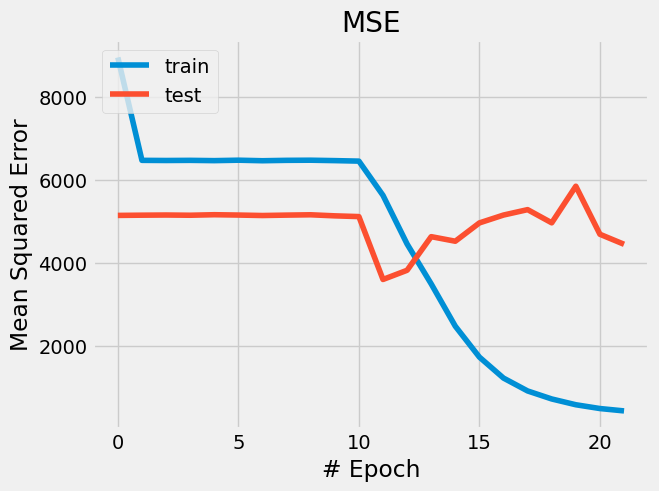

In [38]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('MSE')
plt.ylabel('Mean Squared Error')
plt.xlabel('# Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Results on Train Set

In [39]:
scores = model.evaluate(x_train, y_train, verbose=1, batch_size=200)
print('MSE: {}'.format(scores[1]))

246/246 [==============================] - 13s 53ms/step - loss: 669.4578 - mse: 669.4578
MSE: 669.457763671875


### Results on Test Set

In [40]:
scores_test = model.evaluate(x_test, y_test, verbose=2)
print('MSE: {}'.format(scores_test[1]))

8/8 - 0s - loss: 14802.3662 - mse: 14802.3662 - 139ms/epoch - 17ms/step
MSE: 14802.3662109375


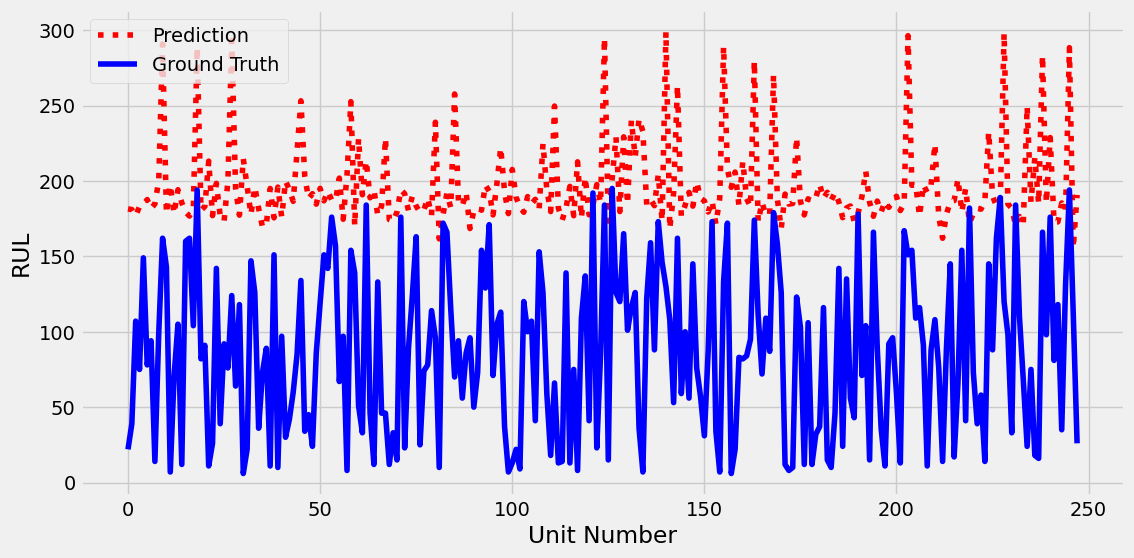

In [41]:
y_pred_test = model.predict(x_test, verbose=0)

np.savetxt('D:/timetofailure/predsae.csv',y_pred_test, delimiter=',')
np.savetxt('D:/timetofailure/truevalsae.csv',y_test, delimiter=',')
plt.figure(figsize=(12,6))
plt.plot(y_pred_test, color='red', label='Prediction',  linestyle='dotted')
plt.plot(y_test, color='blue', label='Ground Truth')
plt.ylabel("RUL")
plt.xlabel("Unit Number")
plt.legend(loc='upper left')
plt.show()